#라이브러리 및 데이터로드

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
plt.style.use("ggplot")
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

import warnings
warnings.filterwarnings("ignore")

In [12]:
weather = pd.read_csv("**")
weather_station_location = pd.read_csv("**")
weather_station_location = weather_station_location.loc[:,["WBAN","NAME","STATE/COUNTRY ID","Latitude","Longitude"]]
weather = weather.loc[:, ["STA", "Date", "MeanTemp"]]

In [13]:
weather.head()

,STA,Date,MeanTemp
0,10001,1942-7-1,23.888889
1,10001,1942-7-2,25.555556
2,10001,1942-7-3,24.444444
3,10001,1942-7-4,24.444444
4,10001,1942-7-5,24.444444


In [14]:
weather_station_location.head()

,WBAN,NAME,STATE/COUNTRY ID,Latitude,Longitude
0,33013,AIN EL,AL,36.383333,6.650000
1,33031,LA SENIA,AL,35.616667,0.583333
2,33023,MAISON BLANCHE,AL,36.716667,3.216667
3,33044,TELERGMA,AL,36.116667,6.416667
4,12001,TINDOUF,AL,27.683333,-8.083333


#전처리

## BINDUKURI지역의 일 평균 온도 대상

In [23]:
#특정 열 추출
weather_station_id = weather_station_location[weather_station_location.NAME=="BINDUKURI"]["WBAN"]
weather_bin = weather[weather["STA"] == int(weather_station_id)]
weather_bin["Date"] = pd.to_datetime(weather_bin["Date"])
weather_bin.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 751 entries, 78252 to 79002
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   STA       751 non-null    int64         
 1   Date      751 non-null    datetime64[ns]
 2   MeanTemp  751 non-null    float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 23.5 KB


In [24]:
weather_bin.head()

,STA,Date,MeanTemp
78252,32907,1943-05-11,28.888889
78253,32907,1943-05-12,25.555556
78254,32907,1943-05-13,24.444444
78255,32907,1943-05-14,23.888889
78256,32907,1943-05-15,27.777778


##BINDUKURI 일평균온도 시각화

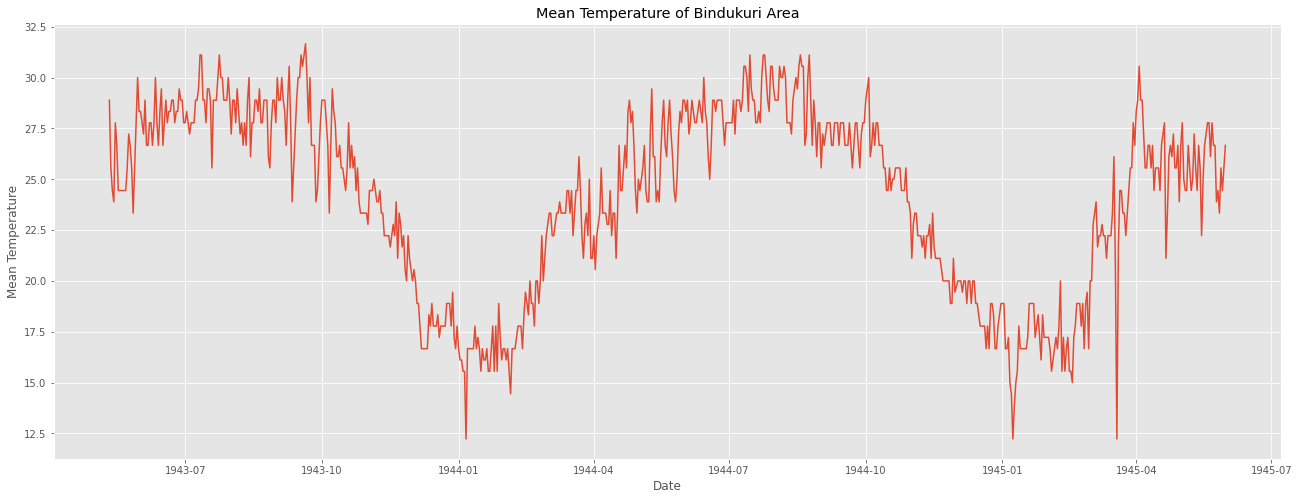

In [25]:
plt.figure(figsize=(22, 8))
plt.plot(weather_bin["Date"], weather_bin["MeanTemp"])
plt.title("Mean Temperature of Bindukuri Area")
plt.xlabel("Date")
plt.ylabel("Mean Temperature")
plt.show()

## 시계열 데이터로 만들어주기

In [27]:
timeSeries = weather_bin.loc[:, ["Date", "MeanTemp"]]
timeSeries.index = timeSeries["Date"]
ts = timeSeries.drop(["Date"], axis=1)
ts.head()

,MeanTemp
Date,
1943-05-11,28.888889
1943-05-12,25.555556
1943-05-13,24.444444
1943-05-14,23.888889
1943-05-15,27.777778


In [55]:
ts.tail()

,MeanTemp
Date,
1945-05-27,23.333333
1945-05-28,25.555556
1945-05-29,24.444444
1945-05-30,25.555556
1945-05-31,26.666667


##시계열 분해(추세, 순환, 계절, 불규칙)

<Figure size 432x288 with 0 Axes>

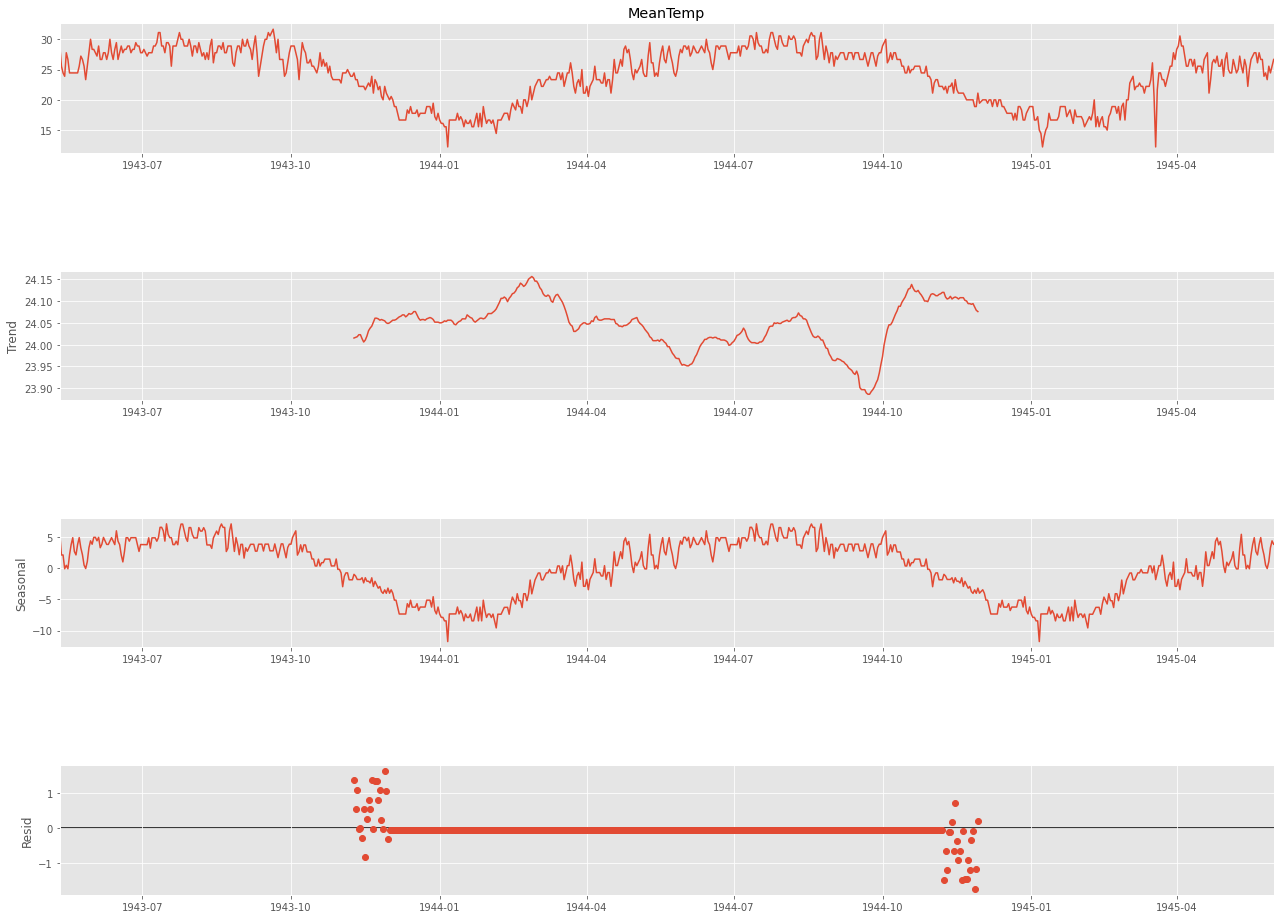

In [32]:
from statsmodels.tsa.seasonal import seasonal_decompose

#덧셈분해 적용
#계절성 주기 7로 초기설정 > 분기별 4 > 월별 12로 설정
result = seasonal_decompose(ts["MeanTemp"], model="additive", freq=365)

fig = plt.figure()
fig = result.plot()
fig.set_size_inches(20, 15)

##정상성 검증(ACF: 패턴보임) 시각화


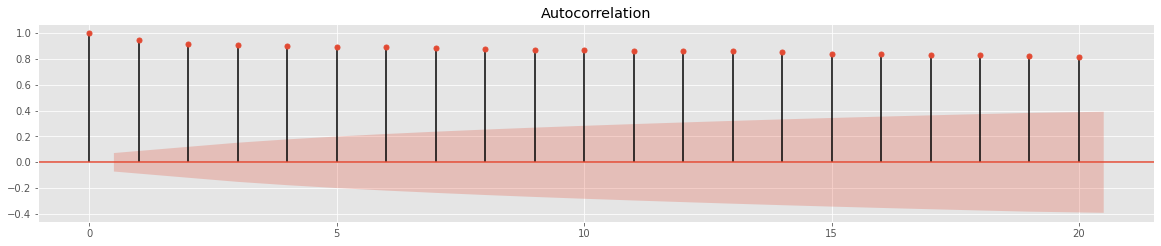

In [33]:
#전 20일과 현재 비교
import statsmodels.api as sm

fig = plt.figure(figsize=(20, 8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(ts, lags=20, ax=ax1)

- 시각화 결과: 값이 아주 천천히 감소하는것 > 정상성을 만족하지 않음
- ADF(단위근 검정)로 정상성 확인

### ADF(단위근검정)
- H0: 정상성 만족하지 않음
- H1: 정상성 만족

In [34]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(ts)
print(result)

print("ADF Statistic: %f" %result[0])
print("p-value: %f" %result[1])
print("Critical Values:")
for key, value in result[4].items():
  print("\t%s: %.3f" %(key, value))

(-1.4095966745887762, 0.5776668028526354, 11, 739, {'1%': -3.439229783394421, '5%': -2.86545894814762, '10%': -2.5688568756191392}, 2474.854578321788)
ADF Statistic: -1.409597
p-value: 0.577667
Critical Values:
	1%: -3.439
	5%: -2.865
	10%: -2.569


- p-value > .05 이상이므로 귀무가설 채택
- 정상성 만족하지 않음
- 계절성 존재, 정상성 만족 안함  -> 1차 차분 필요

##1차 차분(diff)

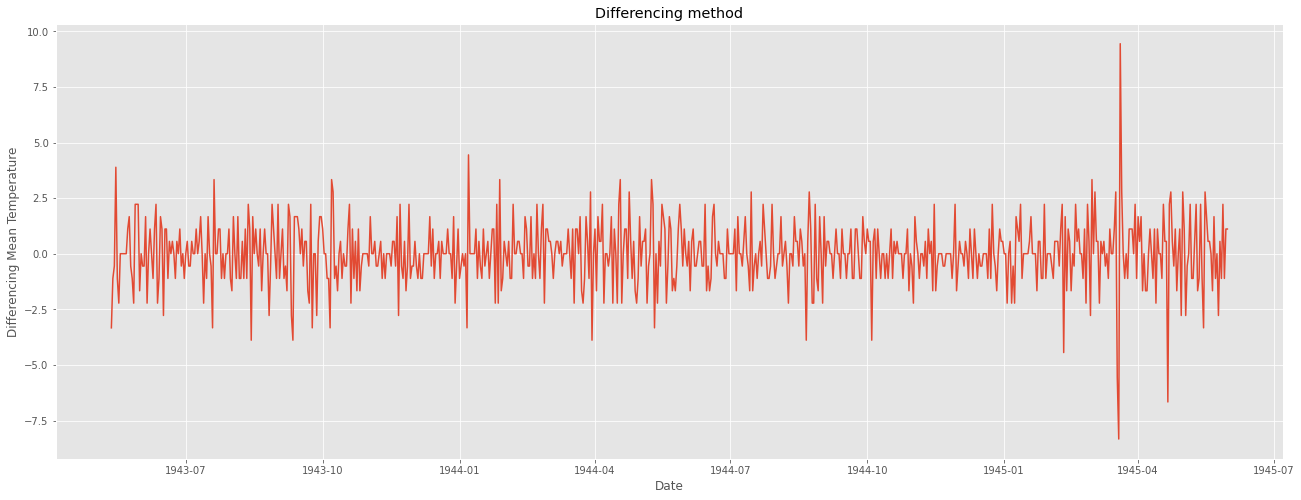

In [37]:
ts_diff = ts - ts.shift()
plt.figure(figsize=(22, 8))
plt.plot(ts_diff)
plt.title("Differencing method")
plt.xlabel("Date")
plt.ylabel("Differencing Mean Temperature")
plt.show()

###ADF(단위근검정)

In [40]:
result = adfuller(ts_diff[1:])
print("ADF Statistic: %f" %result[0])
print("p-value: %f" %result[1])
print("Critical Values:")
for key, value in result[4].items():
  print("\t%s: %.3f" %(key, value))

ADF Statistic: -11.678956
p-value: 0.000000
Critical Values:
	1%: -3.439
	5%: -2.865
	10%: -2.569


- 1차 차분 후 p-value < .05 이므로 대립가설 채택(정상성 만족)
- 정상성을 만족하는 차분된 데이터로 ACF, PACF 그래프 그려 ARIMA의 p, q 결정

##ARIMA p, q 결정

|Model|ACV|PACF|
|:-|:-|:-|
AR(p) | 점차 감소하여 0에 접근 | 시차 p이후에 0
MA(q) | 시차 q이후에 0 | 점차 감소하여 0에 접근
ARMA | 점차 감소하여 0에 접근 | 점차 감소하여 0에 접근
|| (시차 q이후에 0) | (시차 p이후에 0)



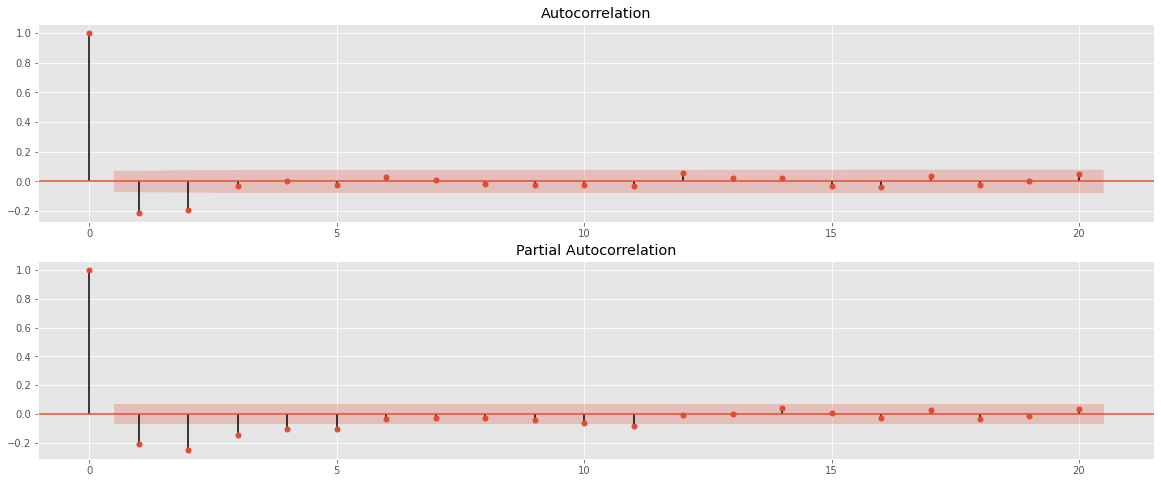

In [41]:
import statsmodels.api as sm

fig = plt.figure(figsize=(20, 8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(ts_diff[1:], lags=20, ax=ax1)

ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(ts_diff[1:], lags=20, ax=ax2)

- ACF, PACF모두 금방 0에 수렴, 2번째 이후 0에 수렴
- ARIMA는(2, 1, 2)

#모델정의 및 예측
- 1994년 6월 25일부터 test
- obs = 340

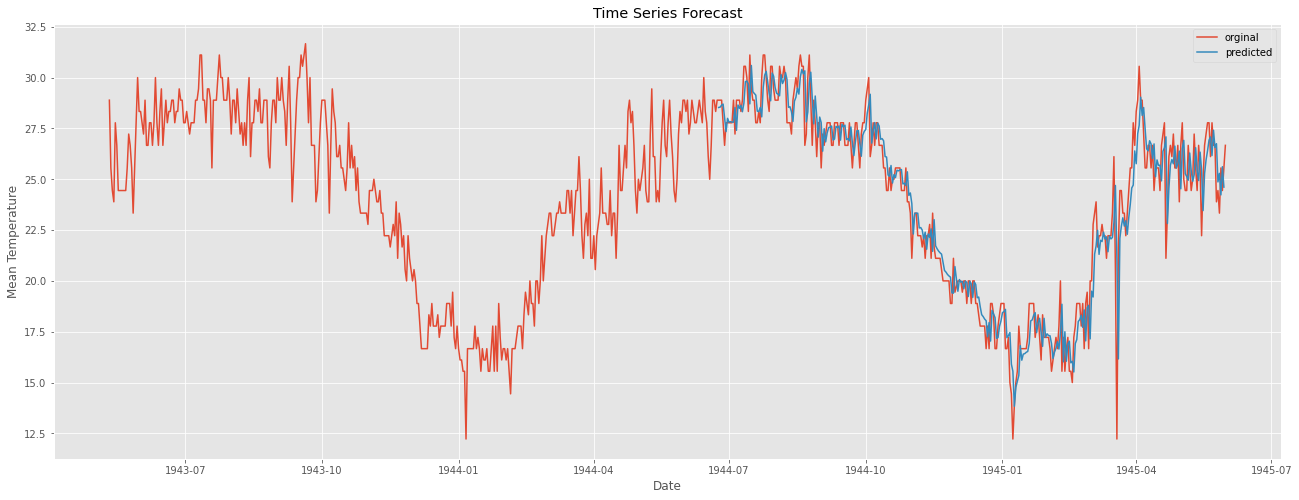

In [62]:
from statsmodels.tsa.arima_model import ARIMA
from pandas import datetime

#fit model
model = ARIMA(ts, order=(2, 1, 2))#원본 시계열 데이터에 ARIMA모델 적용
model_fit = model.fit(disp=0)

#predict
start_index = datetime(1944, 6, 24)
end_index = datetime(1945, 5, 30)
forecast = model_fit.predict(start=start_index,
                             end=end_index, typ="levels") #주의: 차분된 모델의 경우 default(linear)로 설정하면 차분한 값에 대한 결과 나옴

#visualization
plt.figure(figsize=(22, 8))
plt.plot(weather_bin["Date"], weather_bin["MeanTemp"], label="orginal") #전체 그림
plt.plot(forecast, label="predicted")#예측값 그림

plt.title("Time Series Forecast")
plt.xlabel("Date")
plt.ylabel("Mean Temperature")
plt.legend()
plt.show()

#잔차분석
- 잔차는 어떤 패턴이나 특성 나타나서는 안됨

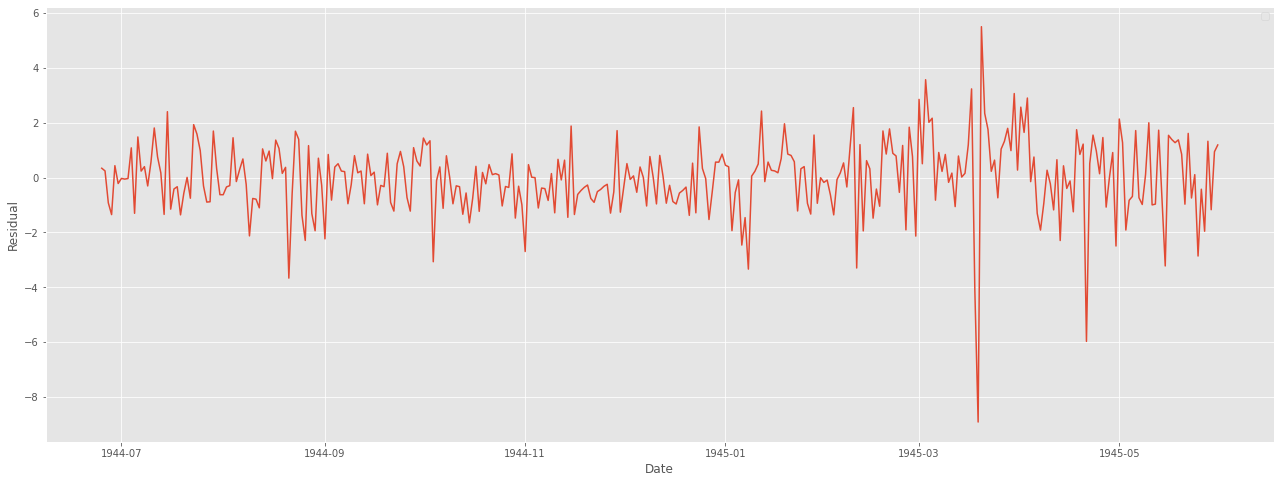

In [45]:
resi = np.array(weather_bin[weather_bin["Date"] >= start_index]["MeanTemp"]) - np.array(forecast)

plt.figure(figsize=(22, 8))
plt.plot(weather_bin["Date"][weather_bin["Date"]>=start_index], resi)
plt.xlabel("Date")
plt.ylabel("Residual")
plt.legend()
plt.show()

## ACF시각화, ADF검정 정상성 판단

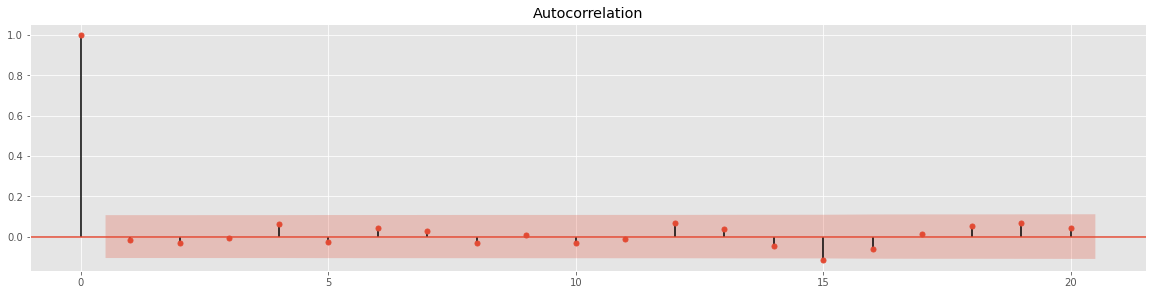

In [46]:
#ACF시각화
fig = plt.figure(figsize=(20, 10))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(resi, lags=20, ax=ax1)

In [47]:
#ADF검정
result = adfuller(resi)
print("ADF Statistic: %f" %result[0])
print("p-value: %f" %result[1])
print("Critical Values:")
for key, value in result[4].items():
  print("\t%s: %.3f" %(key, value))

ADF Statistic: -18.629915
p-value: 0.000000
Critical Values:
	1%: -3.450
	5%: -2.870
	10%: -2.571


- ACF그래프도 빠르게 0으로 수렴<충족)
- ADF검정 역시 p-value < .05로 매우 작음(충족)

#성능확인

In [66]:
from sklearn import metrics

def scoring(y_true, y_pred):
  r2 = round(metrics.r2_score(y_true, y_pred) * 100, 3)
  corr = round(np.corrcoef(y_true, y_pred)[0, 1], 3)
  mape = round(metrics.mean_absolute_percentage_error(y_true, y_pred)*100, 3)
  rmse = round(metrics.mean_squared_error(y_true, y_pred, squared=False), 3)

  df = pd.DataFrame({"R2": r2,
                     "Corr": corr,
                     "RMSE": rmse,
                     "MAPE": mape}, index=[0])
  return df

#y_true: 기존값 / y_pred: 예측값
scoring(np.array(weather_bin[weather_bin["Date"] > start_index]["MeanTemp"]), np.array(forecast))  

,R2,Corr,RMSE,MAPE
0,86.607,0.932,1.667,5.336


In [63]:
weather_bin[weather_bin["Date"] > start_index]["MeanTemp"]

78663    28.888889
78664    28.888889
78665    27.777778
78666    26.666667
78667    27.777778
           ...    
78998    23.333333
78999    25.555556
79000    24.444444
79001    25.555556
79002    26.666667
Name: MeanTemp, Length: 340, dtype: float64

In [64]:
len(np.array(forecast))

340

In [54]:
forecast

Date
1944-06-25    28.546545
1944-06-26    28.644228
1944-06-27    28.697769
1944-06-28    28.015519
1944-06-29    27.342379
                ...    
1945-05-27    25.288861
1945-05-28    24.229767
1945-05-29    25.615679
1945-05-30    24.611111
1945-05-31    25.475966
Length: 340, dtype: float64